# Customer/Card Detection techniques

One of the main challenges of this competition (https://www.kaggle.com/c/ieee-fraud-detection) is **how you obtain the card or the customer whose the transactions, fraudulent or not, belong to.** It has been said that the datasets have all the information to get this, but we faced two problems:
1. It is **anonymized**, they're collected by Vesta’s fraud protection system and digital security partners. 
2. The true meaning of the columns that seems to compose the card or the customer is somewhat obscure too. **The field names are masked** and pairwise dictionary will not be provided for privacy protection and contract agreement.

> For this reason, the identification of both customer or card is one of the most discussed issues in the competition these datasets come from, and the approachs and solutions are quite different.
> **In this notebook, we are based partially on the first approach coming from one of the winners of the competition Chris Deotte teaming with Konstantin Yakovlev. We will use the same analysis techniques, but how we implement the model using this information will finally difer.**


## Our approaches

### `uid1`
We used a simple approach from the more evident columns: 
* `card1`:  Probably, card number given by the issuing company or maybe customer number.
* `addr1`:  Billing address zip code
* `D1achr`: `D1` could be or the days passed between the transaction and the card issue date, or between transaction and the first transaction done with it. For us, this does not really matters, as can be used them both to identify the card. We made this attribute substracting `D1` (in days) to the column `TransactionDelt` (in seconds) with the formula:  

**`D1achr` = `TransactionDT` /(60x60x24) - `D1`**  
**`uid1` = `card1` + `addr1` + `D1achr`**  

---

### `uid2`
Our second approach was to add more card and address field to get the unique card or user id, similar to the choice made by Taemyung Heo (https://www.kaggle.com/c/ieee-fraud-detection/discussion/111696). When doing the FE, this uid has been really helpful, and the aggregations created with this uid improves greatly the model.

**`uid2` = `card1` + `card2` ... + `card6` + `addr1` + `addr2` + `D1achr` + `ProductCD`**

---

### `uid3`

Apart from these approaches, we wanted to replicate the analysis done by Chris Deotte performing adversarial validation which is based on mixing the data from train and test, removing the business target (`isFraud`) and transaction identification columns and runing a model to determine if we can predict which observations are from train and which from test, and assuming that the most important features are strogly related to the customer identification.

https://www.kaggle.com/c/ieee-fraud-detection/discussion/111510

**We will use a combination of the three approaches to create new features that identifies the card and new aggregates from them.**

In [1]:
!pip -q install --upgrade pip
!pip -q install --upgrade seaborn

In [2]:
import gc
import catboost
import lightgbm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore")

In [3]:
##### Functions

def get_denominator(serie):
    
    array_n   = np.array(serie)
    uniques_n = np.unique(array_n[~np.isnan(array_n)])
    
    result  = None
    for i in range(1,1000):
        decimals = uniques_n*i - np.floor(uniques_n*i)

        for decimal in decimals:
            integer = []
            if ((decimal < 0.001) | (decimal > 0.999)):
                integer.append(True)
            else:
                integer.append(False)
                break

        if all(integer):
            result = i
            break

    print('denominator', serie.name, ':', result)
    
def get_fraud_weights(serie):
    
    head        = 10
    values      = list(serie.value_counts(dropna=False).index[:head])
    df_wg_fraud = pd.DataFrame(columns=[serie.name, 'count', 'weight fraud'])
    
    for v in values:
        if (v == v): # is not nan
            n = train.query('{} == "{}" & isFraud == 1'.format(serie.name, v)).shape[0]
            c = train.query('{} == "{}"'.format(serie.name, v)).shape[0]
        else:
            n = train.query('{} != {} & isFraud == 1'.format(serie.name, serie.name)).shape[0]
            c = train.query('{} != {}'.format(serie.name, serie.name)).shape[0]

        w = n/c
        df_wg_fraud = df_wg_fraud.append({serie.name:v, 'count': c, 'weight fraud':w}, ignore_index = True)\
                      .sort_values('weight fraud', ascending=False)
        
    return df_wg_fraud.head(head)

In [4]:
##### Download of files.

print('Downloading datasets...')
print(' ')
train = pd.read_pickle('/kaggle/input/1-ieee-cis-memory-reduction/train_mred.pkl')
print('Train has been downloaded... (1/2)')
test  = pd.read_pickle('/kaggle/input/1-ieee-cis-memory-reduction/test_mred.pkl')
print('Test has been downloaded... (2/2)')
print('Done!')

 
Train has been downloaded... (1/2)
Test has been downloaded... (2/2)
Done!


# Brief Exploratory Data Analysis for the customer related columns
Info and description of the columns from `TransactionID` to `R_emaildomain` and `Di` columns. This can be extended after getting the results of the adversarial validation

In [5]:
##### Info for the colums until R_emaildomain

columns = train.iloc[:,:17]
columns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   TransactionID   590540 non-null  int32  
 1   isFraud         590540 non-null  int8   
 2   TransactionDT   590540 non-null  int32  
 3   TransactionAmt  590540 non-null  float32
 4   ProductCD       590540 non-null  object 
 5   card1           590540 non-null  int16  
 6   card2           581607 non-null  float16
 7   card3           588975 non-null  float16
 8   card4           588963 non-null  object 
 9   card5           586281 non-null  float16
 10  card6           588969 non-null  object 
 11  addr1           524834 non-null  float16
 12  addr2           524834 non-null  float16
 13  dist1           238269 non-null  float32
 14  dist2           37627 non-null   float32
 15  P_emaildomain   496084 non-null  object 
 16  R_emaildomain   137291 non-null  object 
dtypes: float16

In [6]:
##### Main statistics

columns.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540.000000,581607.0,588975.0,586281.0,524834.0,524834.0,238269.000000,37627.000000
mean,3.282270e+06,0.034990,7.372311e+06,134.849594,9898.734658,NaN,NaN,NaN,NaN,NaN,118.489357,231.855423
std,1.704744e+05,0.183755,4.617224e+06,239.162689,4901.170153,NaN,0.0,0.0,NaN,0.0,371.947388,529.039307
min,2.987000e+06,0.000000,8.640000e+04,0.251000,1000.000000,100.0,100.0,100.0,100.0,10.0,0.000000,0.000000
25%,3.134635e+06,0.000000,3.027058e+06,43.320999,6019.000000,214.0,150.0,166.0,204.0,87.0,3.000000,7.000000
50%,3.282270e+06,0.000000,7.306528e+06,68.769001,9678.000000,361.0,150.0,226.0,299.0,87.0,8.000000,37.000000
75%,3.429904e+06,0.000000,1.124662e+07,125.000000,14184.000000,512.0,150.0,226.0,330.0,87.0,24.000000,206.000000
max,3.577539e+06,1.000000,1.581113e+07,31937.390625,18396.000000,600.0,231.0,237.0,540.0,102.0,10286.000000,11623.000000


In [7]:
##### Number of nulls and percentages
#dist1 greater than 90% of nulls

print('Number of NaNs in train (amount):\n', columns.isnull().sum(), sep='')
print(' ')
print('Number of NaNs in train (% of total):\n', columns.isnull().sum()/train.shape[0], sep='')

Number of NaNs in train (amount):
TransactionID          0
isFraud                0
TransactionDT          0
TransactionAmt         0
ProductCD              0
card1                  0
card2               8933
card3               1565
card4               1577
card5               4259
card6               1571
addr1              65706
addr2              65706
dist1             352271
dist2             552913
P_emaildomain      94456
R_emaildomain     453249
dtype: int64
 
Number of NaNs in train (% of total):
TransactionID     0.000000
isFraud           0.000000
TransactionDT     0.000000
TransactionAmt    0.000000
ProductCD         0.000000
card1             0.000000
card2             0.015127
card3             0.002650
card4             0.002670
card5             0.007212
card6             0.002660
addr1             0.111264
addr2             0.111264
dist1             0.596524
dist2             0.936284
P_emaildomain     0.159949
R_emaildomain     0.767516
dtype: float64


`TransactionID` - Transactions identity information.

In [8]:
print('Is transaction unique?:', len(train.TransactionID.unique()) == train.shape[0]) # unique transaction id -> (checking that it is truly unique)

Is transaction unique?: True


`isFraud` - As the transactions have been reported as fraudulent, all the following transactions with the same customer account, billing address, or email address will be also labeled as fraudulent.

In [9]:
print('Fraud unbalance:', train.isFraud.value_counts()[0]/train.shape[0]) # balance legit/totals
print('Fraud correlations: \n', abs(train.corrwith(train.isFraud)).head(10).sort_values(ascending = False), sep='')

Fraud unbalance: 0.9650099908558268
Fraud correlations: 
isFraud           1.000000
card3             0.154151
card5             0.033580
addr2             0.030387
TransactionID     0.014166
card1             0.013640
TransactionDT     0.013103
TransactionAmt    0.011320
addr1             0.005596
card2             0.003388
dtype: float64


`TransactionDT` - Timedelta from a given reference datetime (not an actual timestamp).Delta between the begining of the dataset (86400 secs) and the transaction 183 days, aprox half a year. The unit is a second. We are only using this variable to create `DeltaDays`.

`DeltaDays` = np.floor(`TransactionDT` / 60 / 60 / 24) -> converts seconds to days.

In [10]:
print('TransactionDT min:', train.TransactionDT.min()) # From the discussions, 86400 id 60*60*24, a day in seconds
print('TransactionDT max:', train.TransactionDT.max()) 
print('TransactionDT days (train):', round(train.TransactionDT.max()/train.TransactionDT.min())) # Days in 6 months in train
print('TransactionDT days (test):', round((test.TransactionDT.max()-test.TransactionDT.min())/train.TransactionDT.min())) # Days in 6 months in train

TransactionDT min: 86400
TransactionDT max: 15811131
TransactionDT days (train): 183
TransactionDT days (test): 183


`TransactionAmt` - Transaction amount.

In [11]:
print('TransactionAmt min:', train.TransactionAmt.min())
print('TransactionAmt max:', train.TransactionAmt.max())
print('TransactionAmt mean:', train.TransactionAmt.mean())
print('TransactionAmt correlations: \n', abs(train.corrwith(train.TransactionAmt)).sort_values(ascending = False).head(10), sep='')
print('TransactionAmt fraud weights: \n', get_fraud_weights(train.TransactionAmt), sep='')

TransactionAmt min: 0.25099998712539673
TransactionAmt max: 31937.390625
TransactionAmt mean: 134.84959411621094
TransactionAmt correlations: 
TransactionAmt    1.000000
V139              0.222308
V140              0.207470
V208              0.198601
V161              0.197351
V163              0.191320
V313              0.190256
V270              0.184497
V272              0.183249
V315              0.176778
dtype: float64
TransactionAmt fraud weights: 
   TransactionAmt    count  weight fraud
0      226.000000  11704.0      0.033322
1       49.000000  15990.0      0.029331
2      100.000000  20362.0      0.025685
3      117.000000  28933.0      0.024851
4       39.000000  11095.0      0.021812
5       59.000000  30582.0      0.021124
6       50.000000  17009.0      0.020754
9       29.000000  10683.0      0.018815
7      107.949997  23954.0      0.009226
8       57.950001  23600.0      0.003814


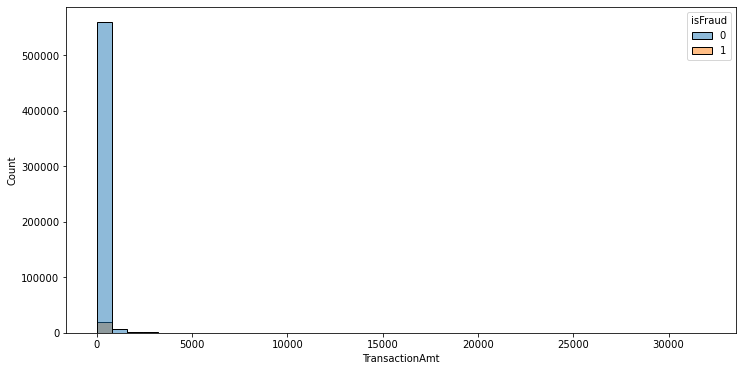

In [12]:
plt.figure(figsize=(12,6))
sns.histplot(data=train, x = 'TransactionAmt', hue='isFraud', bins=40)
plt.show()

`ProductCD` - 5 different product code, the product for each transaction.

In [13]:
print('ProductCD fraud weights: \n', get_fraud_weights(train.ProductCD), sep='')

ProductCD fraud weights: 
  ProductCD   count  weight fraud
0         C   68519      0.116873
4         S   11628      0.058996
1         H   33024      0.047662
2         R   37699      0.037826
3         W  439670      0.020399


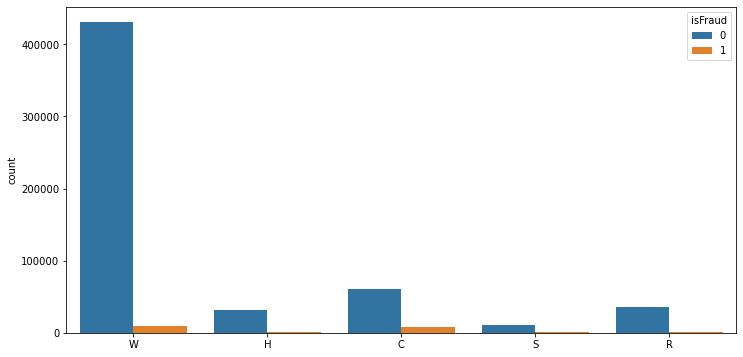

In [14]:
plt.figure(figsize=(12,6))
sns.countplot(x = train.ProductCD.values, hue= train.isFraud)
plt.show()

`card1` - Probably, this is the number or part of the number given by the issuing entity. Categorical. It is not ordinal.

In [15]:
print('card1 values counts: \n', train.card1.value_counts(dropna=False), sep='')
print('card1 fraud weights: \n', get_fraud_weights(train.card1))
print('card1 correlations: \n', abs(train.corrwith(train.card1)).sort_values(ascending = False).head(10))

card1 values counts: 
7919     14932
9500     14162
15885    10361
17188    10344
15066     7945
         ...  
12390        1
10341        1
10006        1
15743        1
17105        1
Name: card1, Length: 13553, dtype: int64
card1 fraud weights: 
      card1    count  weight fraud
9   7585.0   5334.0      0.049306
0   6019.0   6771.0      0.043420
1  15885.0  10361.0      0.042853
2  15066.0   7945.0      0.039396
3   9500.0  14162.0      0.037283
4  12695.0   7091.0      0.028346
5  17188.0  10344.0      0.026875
6  12544.0   6773.0      0.021556
7   2803.0   6141.0      0.011887
8   7919.0  14932.0      0.007501
card1 correlations: 
 card1    1.000000
V330     0.146483
V329     0.142539
V324     0.138616
V333     0.136557
V328     0.134419
V323     0.133649
V332     0.133150
V165     0.127711
V322     0.123626
dtype: float64


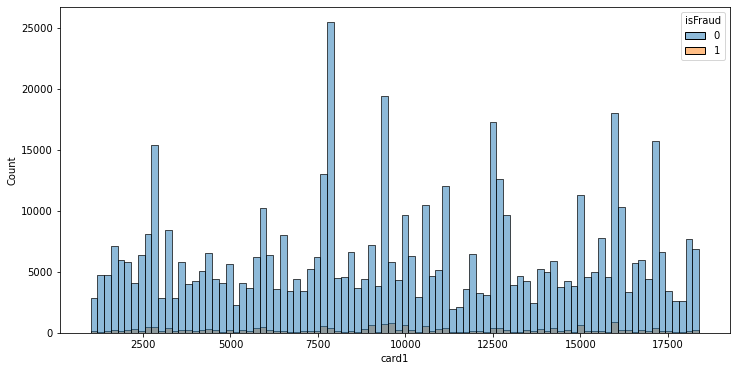

In [16]:
plt.figure(figsize=(12,6))
sns.histplot(data=train, x = 'card1', hue='isFraud')
plt.show()

`card2` - Categorical. Numeric, not ordinal.

In [17]:
print('card2 value counts: \n', train.card2.value_counts(dropna=False).head(10), sep='')
print('card2 fraud weights: \n', get_fraud_weights(train.card2), sep='')
print('card2 correlations: \n', abs(train.corrwith(train.card2)).sort_values(ascending = False).head(10), sep='')

card2 value counts: 
321.0    48935
111.0    45191
555.0    41995
490.0    38145
583.0    21803
170.0    18214
194.0    16938
545.0    16355
360.0    15190
514.0    14541
Name: card2, dtype: int64
card2 fraud weights: 
   card2    count  weight fraud
0  545.0  16355.0      0.086824
9  514.0  14541.0      0.046214
1  583.0  21803.0      0.041233
2  170.0  18214.0      0.031295
3  321.0  48935.0      0.028528
4  490.0  38145.0      0.024014
5  555.0  41995.0      0.022836
6  111.0  45191.0      0.021641
7  360.0  15190.0      0.010402
8  194.0  16938.0      0.007675
card2 correlations: 
card2    1.000000
V302     0.097911
V304     0.096949
V303     0.092447
V50      0.084508
V71      0.081179
V31      0.081149
V42      0.079889
V21      0.079678
V32      0.079543
dtype: float64


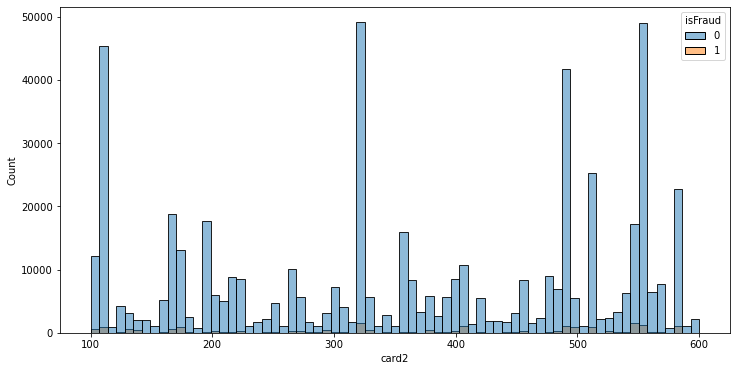

In [18]:
plt.figure(figsize=(12,6))
sns.histplot(data=train, x = 'card2', hue='isFraud')
plt.show()

`card3` - Categorical.

In [19]:
print('card3 value counts: \n', train.card3.value_counts(dropna=False).head(10), sep='')
print('card3 fraud weights: \n', get_fraud_weights(train.card3), sep='')
print('card3 correlations: \n', abs(train.corrwith(train.card3)).sort_values(ascending = False).head(10), sep='')

card3 value counts: 
150.0    521287
185.0     56346
106.0      1571
NaN        1565
146.0      1252
144.0      1252
117.0       962
143.0       899
119.0       750
102.0       460
Name: card3, dtype: int64
card3 fraud weights: 
   card3     count  weight fraud
0  185.0   56346.0      0.130657
1  119.0     750.0      0.093333
2  144.0    1252.0      0.089457
3  143.0     899.0      0.031146
4    NaN    1565.0      0.024920
5  150.0  521287.0      0.024568
9  102.0     460.0      0.023913
6  146.0    1252.0      0.019968
7  117.0     962.0      0.018711
8  106.0    1571.0      0.015277
card3 correlations: 
card3    1.000000
V15      0.759508
V94      0.758586
V16      0.744826
V57      0.744299
V79      0.738073
V33      0.733222
V50      0.731792
V51      0.731570
V58      0.719275
dtype: float64


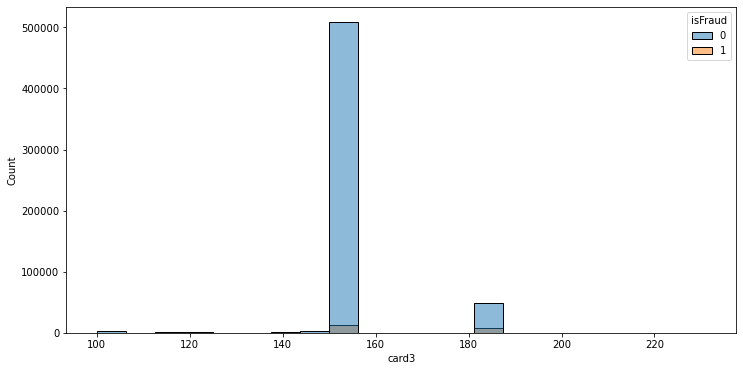

In [20]:
plt.figure(figsize=(12,6))
sns.histplot(data=train, x = 'card3', hue='isFraud')
plt.show()

`card4` - Card payments company. Categorical, strings.

In [21]:
print('card4 value counts: \n', train.card4.value_counts(dropna=False).head(10), sep='')
print('card4 fraud weights: \n', get_fraud_weights(train.card4), sep='')

card4 value counts: 
visa                384767
mastercard          189217
american express      8328
discover              6651
NaN                   1577
Name: card4, dtype: int64
card4 fraud weights: 
              card4   count  weight fraud
0          discover    6651      0.077282
1              visa  384767      0.034756
2        mastercard  189217      0.034331
3  american express    8328      0.028698
4               NaN    1577      0.025999


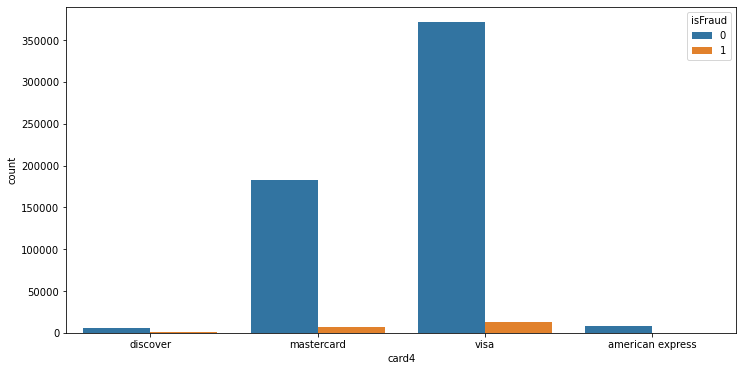

In [22]:
plt.figure(figsize=(12,6))
sns.countplot(data=train, x = 'card4', hue='isFraud')
plt.show()

`card5` - Numeric, categorical.

In [23]:
print('card5 value counts: \n', train.card5.value_counts(dropna=False).head(10), sep='')
print('card5 fraud weights: \n', get_fraud_weights(train.card5), sep='')
print('card5 correlations: \n', abs(train.corrwith(train.card5)).sort_values(ascending = False).head(10), sep='')

card5 value counts: 
226.0    296546
224.0     81513
166.0     57140
102.0     29105
117.0     25941
138.0     19737
195.0     16945
137.0     11720
126.0     10298
219.0      9924
Name: card5, dtype: int64
card5 fraud weights: 
   card5     count  weight fraud
0  137.0   11720.0      0.147184
1  138.0   19737.0      0.085221
2  102.0   29105.0      0.062945
9  219.0    9924.0      0.057537
3  195.0   16945.0      0.040189
4  224.0   81513.0      0.038669
5  226.0  296546.0      0.029516
6  117.0   25941.0      0.013646
7  166.0   57140.0      0.011026
8  126.0   10298.0      0.010196
card5 correlations: 
card5    1.000000
V330     0.289202
V329     0.282868
V328     0.270129
V324     0.268091
V333     0.265948
V323     0.260365
V332     0.259082
V327     0.243258
V322     0.238320
dtype: float64


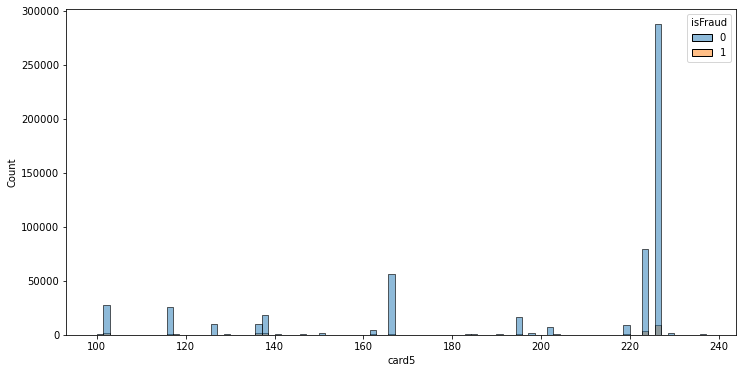

In [24]:
plt.figure(figsize=(12,6))
sns.histplot(data=train, x = 'card5', hue='isFraud')
plt.show()

`card6` - Card type. Categorical, strings.

In [25]:
print('card6 value counts: \n', train.card6.value_counts(dropna=False).head(10), sep='')
print('card6 fraud weights: \n', get_fraud_weights(train.card6), sep='')

card6 value counts: 
debit              439938
credit             148986
NaN                  1571
debit or credit        30
charge card            15
Name: card6, dtype: int64
card6 fraud weights: 
             card6   count  weight fraud
0           credit  148986      0.066785
1              NaN    1571      0.024825
2            debit  439938      0.024263
3  debit or credit      30      0.000000
4      charge card      15      0.000000


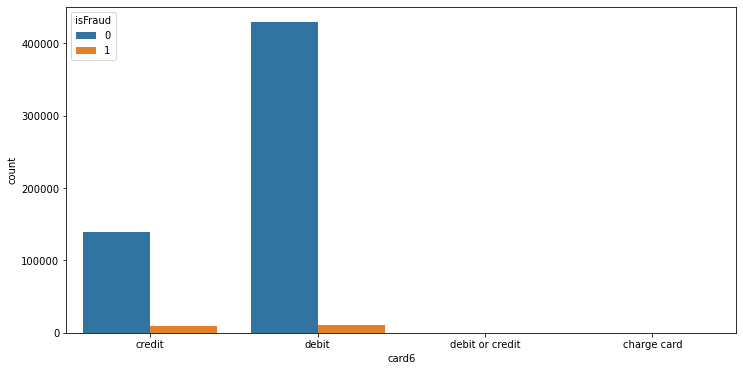

In [26]:
plt.figure(figsize=(12,6))
sns.countplot(data=train, x = 'card6', hue='isFraud')
plt.show()

`addr1` - This is the billing region or zip code. It is used to identify unique cards or user ids. In the real world, the zip codes are different between countries, but in the dataset, there are not many different ones: that depends on how the anonymization was done. This information has been analyzed in previous notebook, and it is part of the identification of a card.

In [27]:
print('addr1 value counts: \n', train.addr1.value_counts(dropna=False).head(10), sep='')
print('addr1 fraud weights: \n', get_fraud_weights(train.addr1), sep='') # NaN values have 11,7 % fraud vs 3.5%
print('addr1 correlations: \n', abs(train.corrwith(train.addr1).sort_values(ascending = False)).head(15), sep='') # Hight correlation

addr1 value counts: 
NaN      65706
299.0    46335
325.0    42751
204.0    42020
264.0    39870
330.0    26287
315.0    23078
441.0    20827
272.0    20141
123.0    16105
Name: addr1, dtype: int64
addr1 fraud weights: 
   addr1    count  weight fraud
0    NaN  65706.0      0.117813
1  330.0  26287.0      0.031955
2  272.0  20141.0      0.028598
3  204.0  42020.0      0.026654
4  441.0  20827.0      0.025592
5  325.0  42751.0      0.025426
9  123.0  16105.0      0.024713
6  299.0  46335.0      0.021258
7  264.0  39870.0      0.018259
8  315.0  23078.0      0.017809
addr1 correlations: 
addr1    1.000000
V326     0.050944
D13      0.050886
V327     0.047731
V330     0.042601
V329     0.042381
V324     0.040680
V323     0.039966
V333     0.039882
V175     0.039571
V332     0.038868
V183     0.038237
V168     0.038041
V179     0.037672
V182     0.037324
dtype: float64


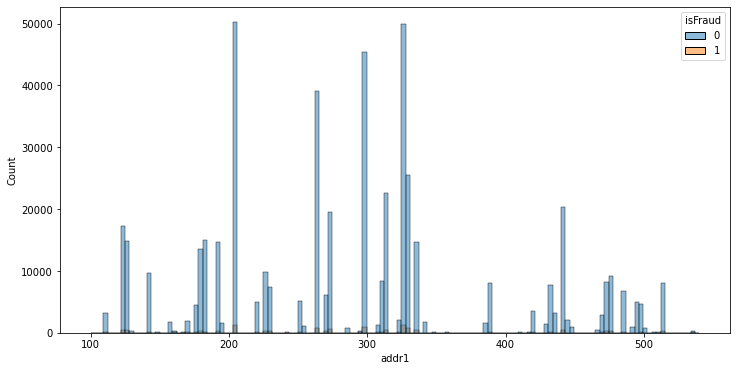

In [28]:
plt.figure(figsize=(12,6))
sns.histplot(data=train, x = 'addr1', hue='isFraud')
plt.show()

`addr2` - This is the billing country.

In [29]:
print('addr2 value counts: \n', train.addr2.value_counts(dropna=False).head(10), sep='')
print('addr2 fraud weights: \n', get_fraud_weights(train.addr2), sep='') # Country 65 has ~50% of fraud!!
print('addr2 correlations: \n', abs(train.corrwith(train.addr2)).sort_values(ascending = False).head(15), sep='') # High correlation with card3

addr2 value counts: 
87.0    520481
NaN      65706
60.0      3084
96.0       638
32.0        91
65.0        82
16.0        55
31.0        47
19.0        33
26.0        25
Name: addr2, dtype: int64
addr2 fraud weights: 
   addr2     count  weight fraud
0   65.0      82.0      0.536585
1   96.0     638.0      0.139498
2    NaN   65706.0      0.117813
3   60.0    3084.0      0.090467
4   32.0      91.0      0.065934
5   87.0  520481.0      0.023972
6   16.0      55.0      0.000000
7   31.0      47.0      0.000000
8   19.0      33.0      0.000000
9   26.0      25.0      0.000000
addr2 correlations: 
addr2    1.000000
V79      0.890125
V57      0.876965
V58      0.876798
V15      0.819340
V16      0.712508
V51      0.632249
V94      0.607043
V33      0.603107
V73      0.569617
card3    0.569108
V52      0.558352
V34      0.518160
V50      0.513401
V71      0.499160
dtype: float64


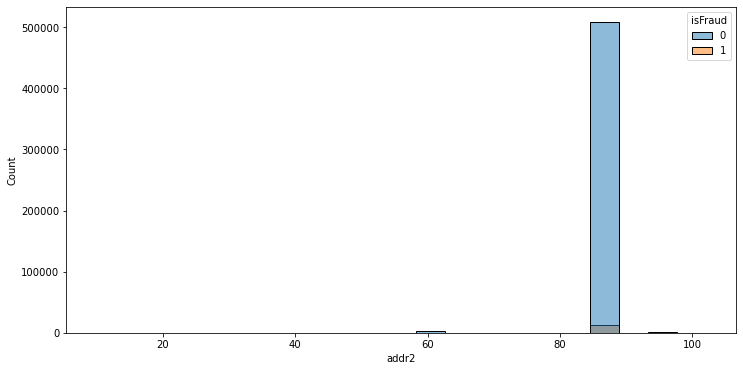

In [30]:
plt.figure(figsize=(12,6))
sns.histplot(data=train, x = 'addr2', hue='isFraud')
plt.show()

In [31]:
##### Inspecting addr1 and addr2 Nans
# When addr1 is null, then addr2 is null too (and the other way around). Try filling NaNs with -999.

print('addr1 null if addr not null (train):', train.query('addr1!=addr1 & addr2==addr2').shape)
print('addr2 null if add2 not null (train):', train.query('addr2!=addr2 & addr1==addr1').shape)
print('addr1 null if addr not null (test):' , test.query('addr1!=addr1 & addr2==addr2').shape)
print('addr2 null if add2 not null (test):' , test.query('addr2!=addr2 & addr1==addr1').shape)

addr1 null if addr not null (train): (0, 405)
addr2 null if add2 not null (train): (0, 405)
addr1 null if addr not null (test): (0, 404)
addr2 null if add2 not null (test): (0, 404)


`P_emaildomain` - This is the mail domain of the purchaser.

In [32]:
# NaNs to be filled with the mode of the card, the rest with unknown and then to -999

print('P_emaildomain value counts: \n', train.P_emaildomain.value_counts(dropna=False).head(10), sep='')
print('P_emaildomain fraud weights: \n:', get_fraud_weights(train.P_emaildomain), sep='')

P_emaildomain value counts: 
gmail.com        228355
yahoo.com        100934
NaN               94456
hotmail.com       45250
anonymous.com     36998
aol.com           28289
comcast.net        7888
icloud.com         6267
outlook.com        5096
msn.com            4092
Name: P_emaildomain, dtype: int64
P_emaildomain fraud weights: 
:   P_emaildomain   count  weight fraud
0    outlook.com    5096      0.094584
1    hotmail.com   45250      0.052950
2      gmail.com  228355      0.043542
3     icloud.com    6267      0.031434
4    comcast.net    7888      0.031187
5            NaN   94456      0.029538
6  anonymous.com   36998      0.023217
7      yahoo.com  100934      0.022757
9        msn.com    4092      0.021994
8        aol.com   28289      0.021811


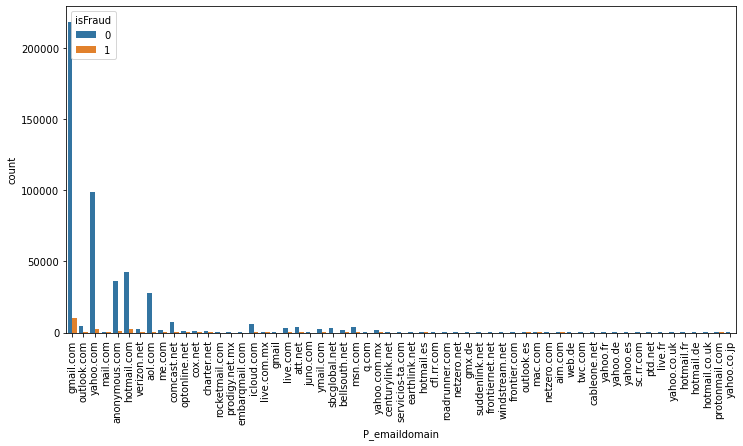

In [33]:
plt.figure(figsize=(12,6))
sns.countplot(data=train, x = 'P_emaildomain', hue='isFraud')
plt.xticks(rotation=90)
plt.show()

`R_emaildomain` - This is the mail domain of the recipient.

In [34]:
# NaNs to be filled with the mode of the card, the rest with unknown and then to -999

print('R_emaildomain value counts: \n', train.R_emaildomain.value_counts(dropna=False).head(10), sep='')
print('R_emaildomain fraud weights: \n:', get_fraud_weights(train.R_emaildomain), sep='')

R_emaildomain value counts: 
NaN              453249
gmail.com         57147
hotmail.com       27509
anonymous.com     20529
yahoo.com         11842
aol.com            3701
outlook.com        2507
comcast.net        1812
yahoo.com.mx       1508
icloud.com         1398
Name: R_emaildomain, dtype: int64
R_emaildomain fraud weights: 
:   R_emaildomain     count  weight fraud
0    outlook.com    2507.0      0.165138
9     icloud.com    1398.0      0.128755
1      gmail.com   57147.0      0.119184
2    hotmail.com   27509.0      0.077793
3      yahoo.com   11842.0      0.051512
4        aol.com    3701.0      0.034855
5  anonymous.com   20529.0      0.029130
6            NaN  453249.0      0.020819
7    comcast.net    1812.0      0.011589
8   yahoo.com.mx    1508.0      0.010610


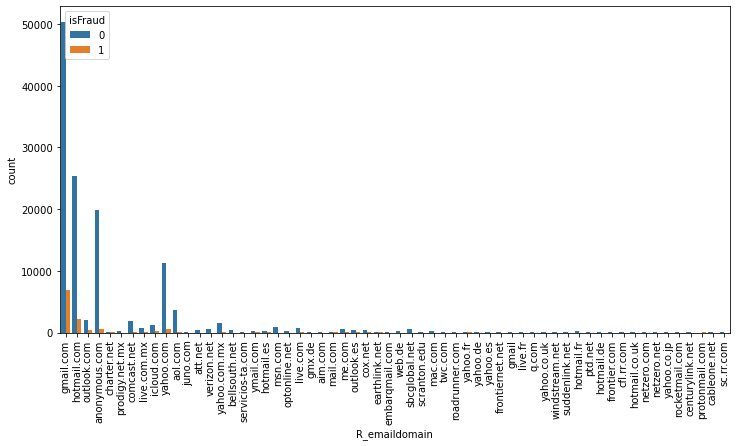

In [35]:
plt.figure(figsize=(12,6))
sns.countplot(data=train, x = 'R_emaildomain', hue='isFraud')
plt.xticks(rotation=90)
plt.show()

`dist1` - Distance between, but not limited to, billing address, delivery address, telephonic area, etc.

In [36]:
print('dist1 value counts: \n', train.dist1.value_counts(dropna=False).head(10), sep='')
print('dist1 fraud weights: \n', get_fraud_weights(train.dist1), sep='')
print('dist1 correlations: \n', train.corrwith(train.dist1).sort_values(ascending = False).head(15), sep='')

dist1 value counts: 
NaN    352271
0.0     19824
1.0     18330
2.0     17028
4.0     13067
3.0     12808
5.0     12004
6.0      9843
7.0      9340
8.0      7731
Name: dist1, dtype: int64
dist1 fraud weights: 
   dist1     count  weight fraud
0    NaN  352271.0      0.045158
1    1.0   18330.0      0.027932
2    5.0   12004.0      0.022243
3    0.0   19824.0      0.019169
4    4.0   13067.0      0.016454
9    8.0    7731.0      0.015134
5    7.0    9340.0      0.014668
6    6.0    9843.0      0.014630
7    2.0   17028.0      0.011745
8    3.0   12808.0      0.011711
dist1 correlations: 
dist1      1.000000
V8         0.094938
V9         0.088465
V2         0.079191
V6         0.076624
V3         0.067514
V5         0.066096
V7         0.064196
V4         0.063953
D11achr    0.059458
D10achr    0.058492
V298       0.042840
V296       0.042598
V280       0.041627
D15achr    0.039997
dtype: float64


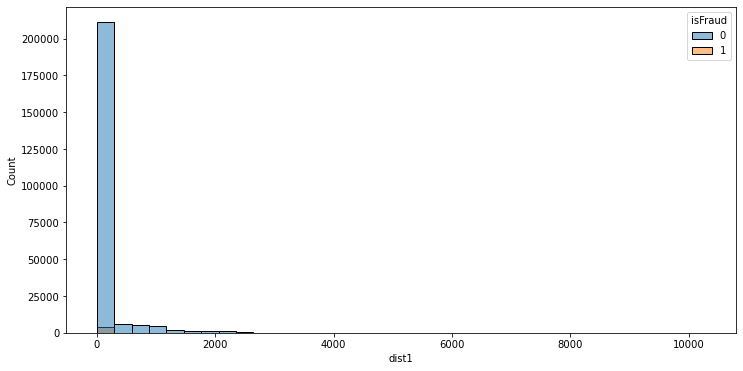

In [37]:
plt.figure(figsize=(12,6))
sns.histplot(data=train, x = 'dist1', hue='isFraud', bins=35)
plt.show()

`dist2` - Distance between, but not limited to, billing address, delivery address, telephonic area, etc.

In [38]:
print('dist2 value counts: \n', train.dist2.value_counts(dropna=False).head(10), sep='')
print('dist2 fraud weights: \n', get_fraud_weights(train.dist2), sep='')
print('dist2 correlations: \n', train.corrwith(train.dist2).sort_values(ascending = False).head(15), sep='')

dist2 value counts: 
NaN     552913
7.0       5687
0.0       3519
1.0       1374
9.0        742
4.0        659
2.0        556
3.0        490
68.0       485
6.0        412
Name: dist2, dtype: int64
dist2 fraud weights: 
   dist2     count  weight fraud
0    0.0    3519.0      0.153453
1    9.0     742.0      0.148248
2    1.0    1374.0      0.139738
3   68.0     485.0      0.096907
4    7.0    5687.0      0.087216
5    3.0     490.0      0.077551
6    4.0     659.0      0.071320
7    2.0     556.0      0.035971
8    NaN  552913.0      0.030623
9    6.0     412.0      0.024272
dist2 correlations: 
dist2      1.000000
V192       0.102090
V187       0.094572
V193       0.091043
V234       0.076003
V191       0.066564
D12achr    0.065523
V196       0.063578
V203       0.058230
V215       0.052907
V207       0.051919
D4achr     0.049898
V172       0.049451
V43        0.045304
V180       0.045130
dtype: float64


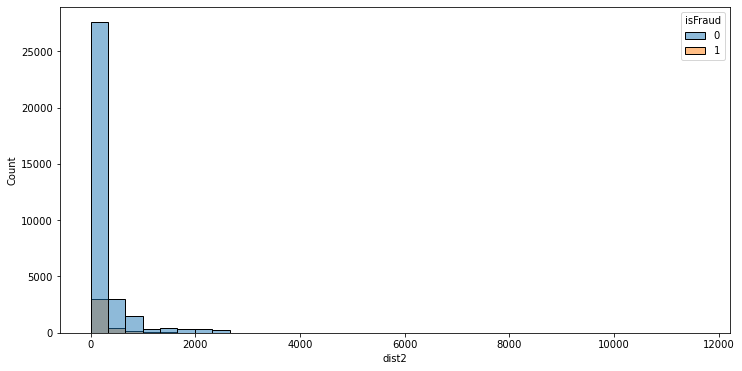

In [39]:
plt.figure(figsize=(12,6))
sns.histplot(data=train, x = 'dist2', hue='isFraud', bins=35)
plt.show()

`Di columns`

In [40]:
# All are in days, except D8 and probably D9. D8, D9 look they are in hours, not in days.

for col in list(train.iloc[:,31:46]):
    print(col, ':', len(train[col].value_counts()))
    
print('#' * 50)    
get_denominator(train['D8'])
get_denominator(train['D9'])

D1 : 641
D2 : 641
D3 : 649
D4 : 808
D5 : 688
D6 : 829
D7 : 597
D8 : 12353
D9 : 24
D10 : 818
D11 : 676
D12 : 635
D13 : 577
D14 : 802
D15 : 859
##################################################
denominator D8 : 24
denominator D9 : 24


In [41]:
# D6, D7, D8, D9, D12, D13, D14 about 90% nulls

print(train.iloc[:,31:46].describe())
print()
print('D null count: \n', train.iloc[:,31:46].isnull().sum()/train.shape[0], sep='')

             D1        D2        D3        D4        D5       D6       D7  \
count  589271.0  309743.0  327662.0  421618.0  280699.0  73187.0  38917.0   
mean        NaN       NaN       NaN       NaN       NaN      NaN      inf   
std         NaN       NaN       NaN       NaN       NaN      NaN      inf   
min         0.0       0.0       0.0    -122.0       0.0    -83.0      0.0   
25%         0.0      26.0       1.0       0.0       1.0      0.0      0.0   
50%         3.0      97.0       8.0      26.0      10.0      0.0      0.0   
75%       122.0     276.0      27.0     253.0      32.0     40.0     17.0   
max       640.0     640.0     819.0     869.0     819.0    873.0    843.0   

                 D8            D9       D10       D11      D12      D13  \
count  74926.000000  74926.000000  514518.0  311253.0  64717.0  61952.0   
mean     146.088898      0.560059       NaN       NaN      inf      inf   
std      231.653519      0.316650       NaN       NaN      inf      inf   
min   

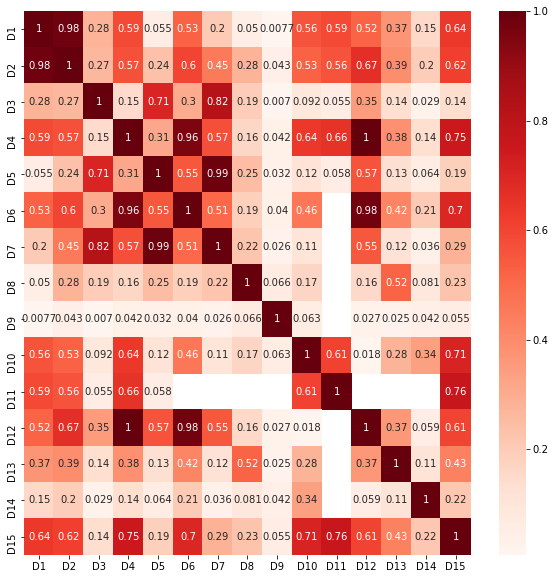

In [42]:
plt.figure(figsize=(10,10))
sns.heatmap(train.iloc[:,31:46].corr(), annot=True, fmt='.2g', cmap='Reds')
plt.show()

In [43]:
#D3 days from the previous card transaction, D5 and D7 looks something similar. D3 and D5 quite similar. Probably we will remove D7, but due to it gets 93% of NaNs.

train.iloc[:,31:46].query('D3==D3 & D5==D5 & D7==D7 & D5!=D7')[['D3', 'D5', 'D7']].head(10)

,D3,D5,D7
42066,357.0,357.0,177.0
45454,379.0,379.0,673.0
45755,141.0,141.0,365.0
48574,180.0,180.0,1.0
51616,202.0,202.0,356.0
68517,139.0,139.0,183.0
70325,366.0,366.0,185.0
72234,54.0,54.0,364.0
74372,0.0,356.0,367.0
77313,41.0,41.0,215.0


# Adversarial Validation

## Analysis of the first 54 columns

In [44]:
##### Adding the Dxachr columns to perform the validation instead of de original Ds. These columns already come from the binaries loaded.

train_til_M = train.iloc[:,:55].copy()
train_til_M = train_til_M.drop('isFraud', axis=1)
train_til_M['is_train'] = 1

train_til_M = pd.concat([train_til_M, train.iloc[:,-10:]], axis=1)

test_til_M = test.iloc[:,:54].copy()
test_til_M['is_train'] = 0
test_til_M = pd.concat([test_til_M, test.iloc[:,-10:]], axis=1)

train_test_til_M = pd.concat([train_til_M, test_til_M], axis=0, ignore_index=True)

del train_til_M
del test_til_M

gc.collect()

22557

In [45]:
##### Basic Fill NaNs for LGBM: Get categories and preprocess with Label Encoder.

categ_cols = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain']
categ_cols += ['M'+str(i) for i in range(1,10)]

# Replace null by not_know
train_test_til_M.loc[:,categ_cols] = train_test_til_M[categ_cols].fillna('not_know')

# Label Encoder
le = LabelEncoder()
for col in categ_cols:
    le.fit(train_test_til_M[col])
    train_test_til_M[col] = le.transform(train_test_til_M[col])

In [46]:
##### Adversarial Validation - sample

adversarial_val   = train_test_til_M.sample(200000, replace=False)
adversarial_train = train_test_til_M[~train_test_til_M.index.isin(adversarial_val.index)]

In [47]:
##### Remove columns that we know relates to transaction and keep the rest.

features = list(train_test_til_M)
features.remove('TransactionID') 
features.remove('TransactionDT')
features.remove('is_train')

# Remove the original Dxs for those we have the engineered Dxahcrs
columns_D = ['D' + str(i) for i in range(1,16) if i not in [3,5,7,8,9]]
for col in columns_D: 
    features.remove(col)
    
# Target definition
target = 'is_train'

del train_test_til_M

In [48]:
##### Adversarial validation with LGBM

train_data    = lightgbm.Dataset(adversarial_train[features], label=adversarial_train[target], categorical_feature=categ_cols)
test_data     = lightgbm.Dataset(adversarial_val[features], label=adversarial_val[target], categorical_feature=categ_cols)

parameters = {
                    'objective':'binary', # in classification, binary or multiclass
                    'boosting_type':'gbdt', # boosting type, gradient boosting decission trees, dart, goss. Behind XGBoost
                    'metric':'auc',
                    'n_jobs':-1,
                    'learning_rate':0.05,
                    'num_leaves': 2**8,
                    'max_depth':-1,
                    'tree_learner':'serial',
                    'colsample_bytree': 0.7,
                    'subsample_freq':1,
                    'subsample':0.5,      #each tree will use this percentage of rows (randomly). Smaller, improves generalization and speed. Not too low, as we look for overfiting.
                    'n_estimators':1000,  #number of trees. This mean that there will be N trees, that they will be executed one after another, unless early_stopping_rounds condition is met.
                    'max_bin':255,
                    'verbose':-1,
                    'early_stopping_rounds':100, 
                } 

model = lightgbm.train(parameters,
                       train_data,
                       valid_sets=test_data, verbose_eval=200)

Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.996566
[400]	valid_0's auc: 0.997565
[600]	valid_0's auc: 0.997962
[800]	valid_0's auc: 0.998176
[1000]	valid_0's auc: 0.998306
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.998306


In [49]:
##### AUC

print('AUC:',model.best_score.get('valid_0').get('auc'))

AUC: 0.998306073639792


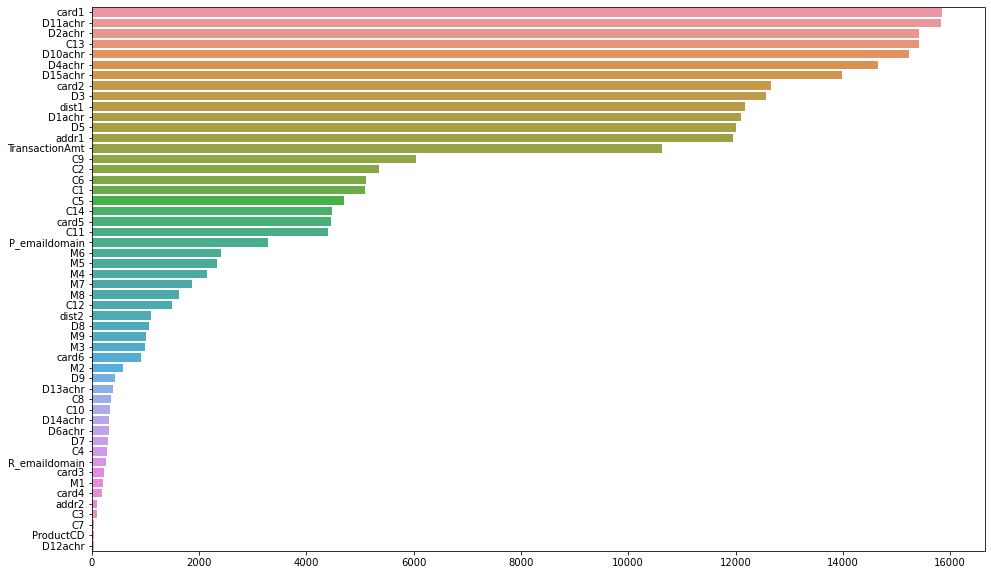

In [50]:
##### Feature Importance

features_importance = model.feature_importance()
features_array = np.array(features)
features_array_ordered_i = features_array[(features_importance).argsort()[::-1]]

plt.figure(figsize=(16,10))
sns.barplot(y=features, x=features_importance, orient='h', order=features_array_ordered_i)
plt.show()

del model

## Analysis of V columns

In [51]:
train_V = train.iloc[:,55:-11:].copy()
train_V['is_train'] = 1


test_V = test.iloc[:,55:-11:].copy()
test_V['is_train'] = 0

train_test_V = pd.concat([train_V, test_V], axis=0, ignore_index=True)

del train_V
del test_V
gc.collect()

12431

In [52]:
##### Adversarial Validation - sample

adversarial_val   = train_test_V.sample(200000, replace=False)
adversarial_train = train_test_V[~train_test_V.index.isin(adversarial_val.index)]

del train_test_V

# Remove columns that we know relates to transaction and keep the rest

features = list(adversarial_train)
features.remove('is_train')

# Target definition

target = 'is_train'

In [53]:
##### Adversarial validation with LGBM

train_data    = lightgbm.Dataset(adversarial_train[features], label=adversarial_train[target])
test_data     = lightgbm.Dataset(adversarial_val[features],   label=adversarial_val[target])

parameters = {
                    'objective':'binary', # in classification, binary or multiclass
                    'boosting_type':'gbdt', # boosting type, gradient boosting decission trees, dart, goss. Behind XGBoost
                    'metric':'auc',
                    'n_jobs':-1,
                    'learning_rate':0.05,
                    'num_leaves': 2**8,
                    'max_depth':-1,
                    'tree_learner':'serial',
                    'colsample_bytree': 0.7,
                    'subsample_freq':1,
                    'subsample':0.5,      #each tree will use this percentage of rows (randomly). Smaller, improves generalization and speed. Not too low, as we look for overfiting.
                    'n_estimators':1000,  #number of trees. This mean that there will be N trees, that they will be executed one after another, unless early_stopping_rounds condition is met.
                    'max_bin':255,
                    'verbose':-1,
                    'early_stopping_rounds':100, 
                } 

model = lightgbm.train(parameters,
                       train_data,
                       valid_sets=test_data, verbose_eval=200)

Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.978348
[400]	valid_0's auc: 0.978755
Early stopping, best iteration is:
[484]	valid_0's auc: 0.978873


In [54]:
##### AUC

print('AUC:',model.best_score.get('valid_0').get('auc'))

AUC: 0.9788734146617585


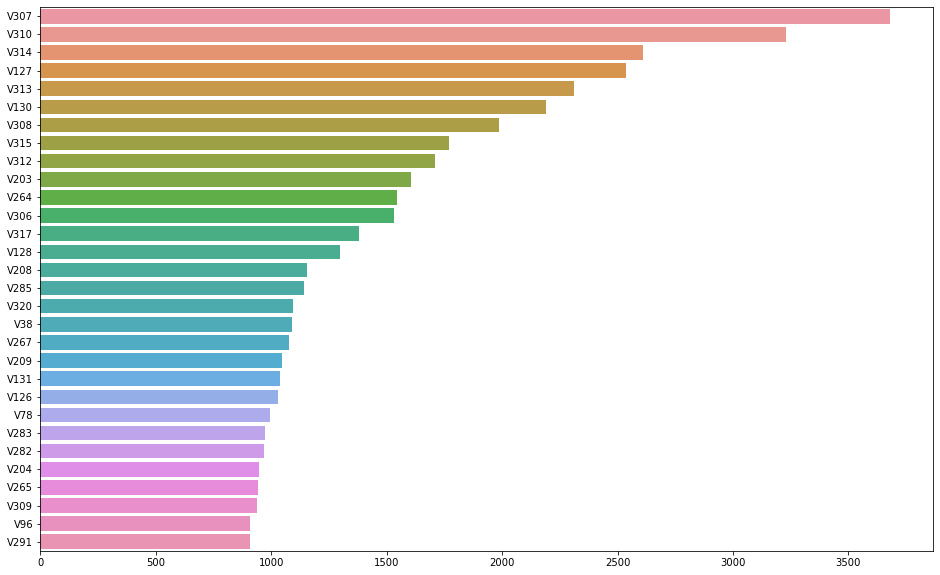

In [55]:
##### Feature Importance

features_importance = model.feature_importance()
features_array = np.array(features)
features_array_ordered_v = features_array[(features_importance).argsort()[::-1]]

plt.figure(figsize=(16,10))
sns.barplot(y=features, x=features_importance, orient='h', order=features_array_ordered_v[:30])
plt.show()

## Finally, we train the model for the adversarial validation with the best 50% of the first batch and the the best 50% of the second

In [56]:
mixed_features_array = np.hstack([
    features_array_ordered_i[:int(np.floor(len(features_array_ordered_i)/2))],
    features_array_ordered_v[:int(np.floor(len(features_array_ordered_v)/2))]])

In [57]:
train_M = train[mixed_features_array].copy()
train_M['is_train'] = 1

test_M = test[mixed_features_array].copy()
test_M['is_train'] = 0

train_test_M = pd.concat([train_M, test_M], axis=0, ignore_index=True)

del train_M
del test_M
del train
del test
gc.collect()

7936

In [58]:
categ_cols = list(train_test_M.dtypes[train_test_M.dtypes == 'O'].index)

train_test_M.loc[:,categ_cols] = train_test_M[categ_cols].fillna('not_know')

le = LabelEncoder()
for col in categ_cols:
    le.fit(train_test_M[col])
    train_test_M[col] = le.transform(train_test_M[col])

In [59]:
##### Adversarial Validation - sample

adversarial_val   = train_test_M.sample(200000, replace=False)
adversarial_train = train_test_M[~train_test_M.index.isin(adversarial_val.index)]

del train_test_M

# Remove columns that we know relates to transaction and keep the rest
features = list(adversarial_train)
features.remove('is_train')

for col in columns_D: # Remove the original Dxs for those we have the engineered Dxahcrs
    try:
        features.remove(col)
    except:
        pass
    
# Target definition
target = 'is_train'

In [60]:
##### Adversarial validation with LGBM

train_data    = lightgbm.Dataset(adversarial_train[features], label=adversarial_train[target], categorical_feature=categ_cols)
test_data     = lightgbm.Dataset(adversarial_val[features],   label=adversarial_val[target],   categorical_feature=categ_cols)

parameters = {
                    'objective':'binary', # in classification, binary or multiclass
                    'boosting_type':'gbdt', # boosting type, gradient boosting decission trees, dart, goss. Behind XGBoost
                    'metric':'auc',
                    'n_jobs':-1,
                    'learning_rate':0.05,
                    'num_leaves': 2**8,
                    'max_depth':-1,
                    'tree_learner':'serial',
                    'colsample_bytree': 0.7,
                    'subsample_freq':1,
                    'subsample':0.5,      #each tree will use this percentage of rows (randomly). Smaller, improves generalization and speed. Not too low, as we look for overfiting.
                    'n_estimators':1000,  #number of trees. This mean that there will be N trees, that they will be executed one after another, unless early_stopping_rounds condition is met.
                    'max_bin':255,
                    'verbose':-1,
                    'early_stopping_rounds':100, 
                } 

model = lightgbm.train(parameters,
                       train_data,
                       valid_sets=test_data, verbose_eval=200)

Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.997952
[400]	valid_0's auc: 0.998492
[600]	valid_0's auc: 0.998703
[800]	valid_0's auc: 0.998797
[1000]	valid_0's auc: 0.998856
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.998856


In [61]:
##### AUC

print('AUC:',model.best_score.get('valid_0').get('auc'))

AUC: 0.9988561076990548


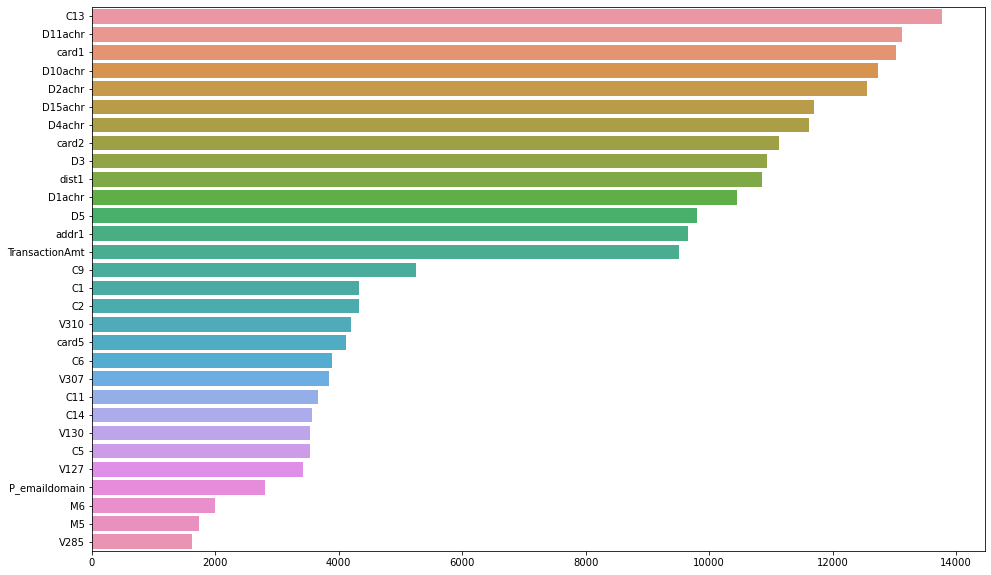

In [62]:
##### Feature Importance

features_importance = model.feature_importance()
features_array = np.array(features)
features_array_ordered_v = features_array[(features_importance).argsort()[::-1]]

plt.figure(figsize=(16,10))
sns.barplot(y=features, x=features_importance, orient='h', order=features_array_ordered_v[:30])
plt.show()

# Conclusions

Attending the adversarial validation, these characteristics can be strongly related to the customer identification:

* `card1` y/o `card2`
* `D1achr` y/o `D11achr`, `D10achr`, `D15achr`, `D4achr`
* `C13`
* `addr1`
* `dist1`

We tested the model outcomes, engineering the features based on this uid, f.e. creating aggregations, against our original (card columns +addr columns + ProductCD + D1achr) and the results were better with the latter than the former. However, these features are also important for the fraud detection model. We are using a mix between these two and the first uid approach in order to obtain new features that help the model to differenciate between fraudulent and legit transactions.